# **ECS 7001 - NN & NNLP**

## **2021/22 Lab 1: Skip-gram Model for Word2Vec**

<br>

**26th and 27th January**

There are two Word2Vec architectures for creating word embeddings: the Continuous Bag of Words (CBOW) architecture and the Skip Gram architecture . In this lab, we will obtain our own word embeddings by training a skip-gram neural network model. Some of the code for this will be supplied here but in some sections, you will be required to implement the code yourself. Hints and
tips will be provided.


The skip gram model is essentially a feedforward neural network with one hidden layer, trained to predict the context word given a target word. There are two ways to train this model: (1) using a hierarchical softmax function and/or (2) by negative sampling. In this lab, we will be training using
negative sampling. To train with negative sampling, the model is cast as a binary classification problem. The dataset would consist of positive and negative examples of the form:

Input | label
--| --
(target_word, word_in_its_context)       |  1 
(target_word, word_not_in_its_context)   |  0

created from the sentences in a corpus. The exact number of positive and negative examples will depend on the window size, and the balance ratio of positive:negative examples.  

As an example, consider the sentence: “ **The quick brown
fox jumped over the lazy dog** ”. For the target word ' **fox** ' and a window size of 2, all the positive and negative examples drawn from this sentence would be:

Input | label
--| --
(fox, the) | 0
(fox, quick) | 1
(fox, brown) | 1
(fox, jumped) | 1
(fox, over) |1
(fox, lazy) | 0
(fox, dog) | 0

The model is trained to learn to predict 1 when a word is in the context of the target word (i.e.in the window of the target word) and 0 otherwise. The model thus learns the statistics of the given corpus: the frequency with two words appear together would determine how similar they are (similarity is usually measured using cosine distance). After training, the trained hidden layer weights are the word embeddings.



### **0. Prepare the environment**

Open Google Colab or activate the virtual environment you’ve created

### **1. Downloading the Corpus**

Our training data will be comprised of 3 documents from the Gutenberg corpus. We can find this and other corpora in nltk https://www.nltk.org/book/ch02.html

In [ ]:
import nltk

nltk.download('punkt')
nltk.download('gutenberg')
from nltk.corpus import gutenberg
austen = gutenberg.sents('austen-sense.txt') + gutenberg.sents('austen-emma.txt') + gutenberg.sents('austen-persuasion.txt') #what exactly is happening here?

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


**Sanity check:**

This training corpus contains 16498 sentences. The following print statement should return 16498.

In [ ]:
print("length before the preprocessed output:",len(austen))

length before the preprocessed output: 16498


In [ ]:
austen[0]

['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']']

### **2. Preprocessing the Training Corpus**

In this section, you will write code to remove special characters, empty strings, digits and
stopwords from the sentences and put all the words into lower cases. You might also consider removing sentences with fewer than 3 words or at least empty sentences.


**Hints:**
*   The corpus can be accessed as you would a tokenized list, a list of lists, each inner list contains all the tokens in the sentence. Eg:
\>> austen[0] =['[', 'Sense', 'and', 'Sensibility', 'by','Jane', 'Austen', '1811', ']']

*   the python <string> library contains a variable “punctuation”, a string containing all
the special characters.

*   You might want to write a function that takes the corpus as an argument and returns the preprocessed corpus as a list of lists.

 Alternatively, you can use the keras preprocessing library to preprocess the text. More information on the library can be found here:
https://keras.io/preprocessing/text/


**Sanity check:**

After preprocessing the corpus, as a sanity check, print the following line of code. If you chose removed sentences of length with fewer than 3 words, it should be about 13651. 

As a test for your preprocessing function, preprocess the sample below and print the output of your function.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
!pip install iteration_utilities

     |████████████████████████████████| 283 kB 10.6 MB/s 


In [ ]:
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import string
from iteration_utilities import deepflatten

In [ ]:
def preprocess_corpus(corpus):
    corpus = [[string.lower() for string in sublist] for sublist in corpus]
    stop_words = stopwords.words('english') #usage of stopwords
    punctuation=list(string.punctuation) #usage of punctuation to delete unwanted punctuation
    stop=stop_words+punctuation #now all words excepted stopwords and unwanted punctuation will be ignored
    stop.extend(['."',"--"]) #adding more punctuations
    filtered_sentence= [[w for w in sublist if not w in stop] for sublist in corpus]
    filtered_sentence=[[i for i in sublist if not i.isdigit()] for sublist in filtered_sentence]


    filtered_sentence= [sublist for sublist in filtered_sentence if len(sublist) >= 4]
    return filtered_sentence


normalized_corpus = preprocess_corpus(austen)
print('The new length of the preprocessed output:',len(normalized_corpus))

The new length of the preprocessed output: 12716


In [ ]:
sample = austen[:2] + austen[100:102]
preprocessed_sample = preprocess_corpus(sample)


print(len(sample), sample)
print()
print(len(preprocessed_sample), preprocessed_sample)

4 [['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']'], ['CHAPTER', '1'], ['But', ',', 'then', ',', 'if', 'Mrs', '.', 'Dashwood', 'should', 'live', 'fifteen', 'years', 'we', 'shall', 'be', 'completely', 'taken', 'in', '."'], ['"', 'Fifteen', 'years', '!']]

2 [['sense', 'sensibility', 'jane', 'austen'], ['mrs', 'dashwood', 'live', 'fifteen', 'years', 'shall', 'completely', 'taken']]


### **3. Creating the Corpus Vocabulary and Preparing the Data**


To prepare the data for machine learning, you will write code to prepare 3 variables:

1. \<word2idx>: a lookup table, a dictionary of (word index: word) pairs where **word index** is a unique integer assigned to every **unique word** in the corpus.
2. \<idx2word>: a dictionary of (token: token index), a reversal of \<word2idx>. 
3. \<sents_as_ids>: The input to the model cannot be text, rather, each word needs to be represented by a unique integer and each sentence an array of integers.


The incomplete code provided below is just a guide. 

In [ ]:
normalized_corpus_single=[] #disolving the list of list into just one list
for list1 in preprocess_corpus(normalized_corpus):
  for i in list1:
    normalized_corpus_single.append(i)

In [ ]:
normalized_corpus[0]

['sense', 'sensibility', 'jane', 'austen']

In [ ]:
from collections import Counter, OrderedDict

def prepareData(normalized_corpus):
  normalized_corpus_dict={}
  count=Counter(normalized_corpus)
  count=dict(count)
  k=0
  for i,j in count.items():
    normalized_corpus_dict[i]=k
    k=k+1
  return normalized_corpus_dict

word2idx=prepareData(normalized_corpus_single)
idx2word = dict(zip(word2idx.values(), word2idx.keys()))

def prepareSentsAsId(normalized_corpus):
  for list_inside in normalized_corpus:
    for i in list_inside:
      index = list_inside.index(i)
      list_inside[index]=word2idx.get(i) 
  return normalized_corpus

#### sents_as_ids 

In [ ]:
word2idx

{'sense': 0,
 'sensibility': 1,
 'jane': 2,
 'austen': 3,
 'family': 4,
 'dashwood': 5,
 'long': 6,
 'settled': 7,
 'sussex': 8,
 'estate': 9,
 'large': 10,
 'residence': 11,
 'norland': 12,
 'park': 13,
 'centre': 14,
 'property': 15,
 'many': 16,
 'generations': 17,
 'lived': 18,
 'respectable': 19,
 'manner': 20,
 'engage': 21,
 'general': 22,
 'good': 23,
 'opinion': 24,
 'surrounding': 25,
 'acquaintance': 26,
 'late': 27,
 'owner': 28,
 'single': 29,
 'man': 30,
 'advanced': 31,
 'age': 32,
 'years': 33,
 'life': 34,
 'constant': 35,
 'companion': 36,
 'housekeeper': 37,
 'sister': 38,
 'death': 39,
 'happened': 40,
 'ten': 41,
 'produced': 42,
 'great': 43,
 'alteration': 44,
 'home': 45,
 'supply': 46,
 'loss': 47,
 'invited': 48,
 'received': 49,
 'house': 50,
 'nephew': 51,
 'mr': 52,
 'henry': 53,
 'legal': 54,
 'inheritor': 55,
 'person': 56,
 'intended': 57,
 'bequeath': 58,
 'society': 59,
 'niece': 60,
 'children': 61,
 'old': 62,
 'gentleman': 63,
 'days': 64,
 'comfort

### ---------------------

In [ ]:
print('Number of unique words:', len(word2idx))

Number of unique words: 10285


In [ ]:
print('\nSample word2idx: ', list(word2idx.items())[:10])


Sample word2idx:  [('sense', 0), ('sensibility', 1), ('jane', 2), ('austen', 3), ('family', 4), ('dashwood', 5), ('long', 6), ('settled', 7), ('sussex', 8), ('estate', 9)]


In [ ]:
print('\nSample idx2word:', list(idx2word.items())[:10])


Sample idx2word: [(0, 'sense'), (1, 'sensibility'), (2, 'jane'), (3, 'austen'), (4, 'family'), (5, 'dashwood'), (6, 'long'), (7, 'settled'), (8, 'sussex'), (9, 'estate')]


In [ ]:
#sents_as_ids=normalized_corpus_test_1
print('\nSample sents_as_id:', prepareSentsAsId(preprocessed_sample))


Sample sents_as_id: [[0, 1, 2, 3], [68, 5, 195, 593, 33, 594, 286, 595]]


**Sanity Check**

Copy and run the following lines of code:

```
print('Number of unique words:', len(word2idx)**
```
Returns a number between 9800 and 1200, the exact number depends on your preprocessing step. 

```
print('\nSample word2idx: ', list(word2idx.items())[:10])
```

Sample word2idx:  [('sense', 0), ('sensibility', 1), ('jane', 2), ('austen', 3), ('the', 4), ('family', 5), ('dashwood', 6), ('long', 7), ('settled', 8), ('sussex', 9)]


```
print('\nSample idx2word:', list(idx2word.items())[:10])**
```

Sample idx2word: [(1, 'could'), (2, 'would'), (3, 'mr'), (4, 'mrs'), (5, 'must'), (6, 'said'), (7, 'one'), (8, 'much'), (9, 'miss'), (10, 'every')]

```
print('\nSample sents_as_id:', prepareSentsAsId(preprocessed_sample))
```

Sample sents_as_id: [[0, 1, 2, 3], [41, 72, 6, 201, 619, 35, 620, 296, 621]]



After you have created the three variables, set the <vocab_size> and <embed_size> variables with the following commands:

In [ ]:
VOCAB_SIZE = len(word2idx) 
EMBED_SIZE = 100 # We are creating 100D embeddings.

In [ ]:
print('Number of unique words:', len(word2idx))

Number of unique words: 10285


### **4. Generating training instances**


In this section we would generate the training examples of the format shown in introduction using the keras skip-gram generator https://keras.io/preprocessing/sequence/ 

In [ ]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
wids = [[word2idx[w] for w in doc] for doc in normalized_corpus]
skip_grams = [skipgrams(wid, vocabulary_size=VOCAB_SIZE, window_size=4) for wid in wids]
pairs, labels = skip_grams[0][0], skip_grams[0][1]

#view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(len(pairs)):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(austen (3), sensibility (1)) -> 1
(sensibility (1), jane (2)) -> 1
(sensibility (1), estrangement (10224)) -> 0
(austen (3), moonlight (1663)) -> 0
(austen (3), jane (2)) -> 1
(sensibility (1), intruder (6100)) -> 0
(jane (2), steele (3544)) -> 0
(sensibility (1), austen (3)) -> 1
(austen (3), pages (6015)) -> 0
(jane (2), austen (3)) -> 1
(jane (2), inure (9371)) -> 0
(jane (2), sensibility (1)) -> 1


**Sanity Check:**

To view the skip_grams for the first sentence in the training data, run the line of code that follows. The output should look like:

(austen (3), sensibility (1)) -> 1

(austen (3), jane (2)) -> 1

(jane (2), sensibility (1)) -> 1

(jane (2), walked (2639)) -> 0

(jane (2), partridge (7948)) -> 0

(sensibility (1), austen (3)) -> 1

(sensibility (1), beneficial (5587)) -> 0

(sensibility (1), jane (2)) -> 1

(sensibility (1), dreamt (8308)) -> 0

(austen (3), perception (6543)) -> 0

(jane (2), austen (3)) -> 1

(austen (3), imposing (8622)) -> 0


### **5. Building the Skip-gram Neural Network Architecture**

In this section we would be building the skip-gram neural network architecture using the Keras Functional API and the Sequential model introduced in the previous lab. https://keras.io/getting-started/functional-api-guide/ 

In [ ]:
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils.vis_utils import plot_model


The skip-gram model is two input one output feedforward neural network with one hidden layer and this will be built over a series of steps.

####**A. The first step is to initialize and transform the first input using the following lines of code:**

In [ ]:
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
target_word = Input((1,), dtype='int32')


# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer 
# from whose weights we will get the word embeddings.
target_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='target_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=1)(target_word)


# at this point, the input would of the shape (num_inputs x 1 x embed_size) and has to be flattened 
# or reshaped into a (num_inputs x embed_size) tensor.
target_input = Reshape((EMBED_SIZE, ))(target_embedding)

####**B. Write similar code for the ‘context_word’ input.**

In [ ]:
# your code for the context_word goes here
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
context_word = Input((1,), dtype='int32')


# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer 
# from whose weights we will get the word embeddings.
context_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='context_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=1)(context_word)


# at this point, the input would of the shape (num_inputs x 1 x embed_size) and has to be flattened 
# or reshaped into a (num_inputs x embed_size) tensor.
context_input = Reshape((EMBED_SIZE, ))(context_embedding)

####**C. Merge the inputs.**

Recall, each training instance is a (target_word, context_word) combination. Since we are trying to learn the degree of closeness between the two words, the model will compute the cosine distance between the two inputs using the <Dot> layer. https://keras.io/layers/merge/, hence fusing the two inputs into one.


In [ ]:
merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])

####**D. The Output Layer**

Pass the merged inputs (now a vector with a single number the cosine distance between the two input vectors for each word) into a sigmoid activated neuron. The output of this layer is the output of the model.

**Hint**: Use the <Dense> layer ( https://keras.io/layers/core/ ), with a ‘sigmoid’ activation function.

In [ ]:
# your code for the output layer goes here
import tensorflow as tf
out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(merged_inputs)

####**E. Initialize the model:**

In [ ]:
# label is the output of step D.
model = Model(inputs=[target_word, context_word], outputs=[out_layer])  

####**F. Compile the model using the <model.compile> command.** Use Loss = ‘mean_squared_error’, optimizer = ‘rmsprop’.

In [ ]:
model.compile(loss="mean_squared_error", optimizer="rmsprop")

**Sanity check:**

Visualize the model and the model summary by running the following lines of code. 
view the model summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 target_embed_layer (Embedding)  (None, 1, 100)      1028500     ['input_1[0][0]']                
                                                                                                  
 context_embed_layer (Embedding  (None, 1, 100)      1028500     ['input_2[0][0]']                
 )                                                                                            

####**G. Plot the model using ```vis utils```.**

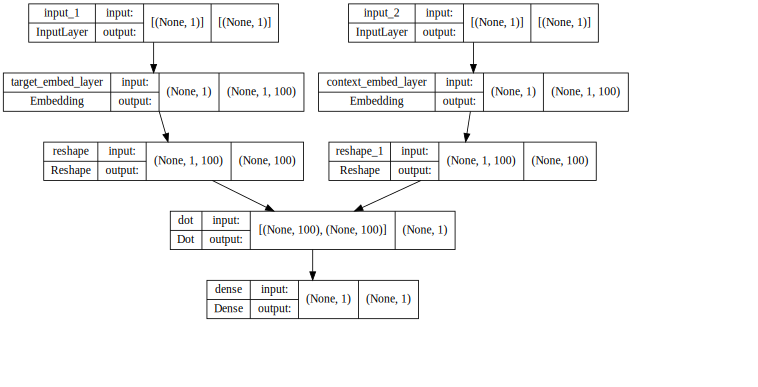

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  


###**6.Training the Model**

Run the following block of code to train the model for 5 epochs:

In [ ]:
VOCAB_SIZE = len(word2idx) 
VOCAB_SIZE

10285

In [ ]:
EMBED_SIZE

100

In [ ]:
import numpy as np

NUM_EPOCHS = 5

for epoch in range(1, NUM_EPOCHS+1):
    epoch_loss = 0
    for i, sent_examples in enumerate(skip_grams):
        #print(sent_examples)
        target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
        context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
        labels = np.array(sent_examples[1], dtype='int32')
        X = [target_wds, context_wds]
        Y = labels
        if i % 5000 == 0: 
        	#print('Processed %d sentences' %i)
          epoch_loss += model.train_on_batch(X, Y)
    print('Processed all %d sentences' %i)
    print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')



Processed all 12715 sentences
Epoch: 1 Loss: 0.7499145418405533 

Processed all 12715 sentences
Epoch: 2 Loss: 0.7473815083503723 

Processed all 12715 sentences
Epoch: 3 Loss: 0.7450541406869888 

Processed all 12715 sentences
Epoch: 4 Loss: 0.7424442023038864 

Processed all 12715 sentences
Epoch: 5 Loss: 0.7394593507051468 



The training takes about 10 minutes to run.

<br>

In the introduction, we outlined two approaches to training using the skipgram architecture. In this tutorial, we implemented the negative sampling training approach. While waiting for the training to complete, read this article http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/. It contains the skipgram model with softmax training. 

<br>

After reading the article, answer the following questions:  
●	What would the inputs and outputs to the model be?

●	How would you use the Keras framework to create this architecture?

●	What are the reasons this training approach is 
considered inefficient?


###**7. Getting the Word Embeddings**

The word embeddings are the weights of the target word embedding layer.


In [ ]:
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0] 

# should return (VOCAB_SIZE, EMBED_SIZE)
print(word_embeddings.shape)

(10285, 100)


Print out a few words and their embeddings using the next block of code. Your output may not be exactly as above but the command should print 10 words and their respective vectors.

In [ ]:
from pandas import DataFrame

print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

                   0         1         2         3         4         5   \
sense        0.011421 -0.014969  0.010833 -0.014109 -0.011458 -0.022278   
sensibility  0.026893  0.019133 -0.010789  0.005050 -0.037341 -0.020763   
jane        -0.025423  0.016799 -0.006891 -0.036728 -0.027626 -0.021483   
austen      -0.005710 -0.023441 -0.006604 -0.010186 -0.019812 -0.000386   
family      -0.020713 -0.020265  0.009221  0.012659  0.001446 -0.009731   
dashwood    -0.011390  0.011597  0.004675 -0.010362  0.002304  0.001367   
long        -0.017342  0.012111 -0.015062  0.015229  0.013776 -0.000436   
settled     -0.004241 -0.015434 -0.020345 -0.008194 -0.015890  0.003723   
sussex      -0.009207  0.005251 -0.017988  0.000976  0.021763 -0.001083   
estate       0.003426  0.008277  0.009064  0.001862  0.017115 -0.007849   

                   6         7         8         9   ...        90        91  \
sense       -0.016098 -0.004706  0.022191  0.009888  ...  0.015120  0.007817   
sensibility -0

In [ ]:
word_df=DataFrame(word_embeddings, index=idx2word.values())
word_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
sense,0.011421,-0.014969,0.010833,-0.014109,-0.011458,-0.022278,-0.016098,-0.004706,0.022191,0.009888,...,0.015120,0.007817,-0.000025,-0.007100,0.020506,-0.002781,-0.020601,-0.010991,0.014706,-0.001632
sensibility,0.026893,0.019133,-0.010789,0.005050,-0.037341,-0.020763,-0.021511,-0.010876,-0.021492,-0.021791,...,0.026239,-0.029278,0.019793,0.016487,-0.002518,-0.028056,0.030725,0.012661,-0.005744,-0.036705
jane,-0.025423,0.016799,-0.006891,-0.036728,-0.027626,-0.021483,-0.011140,0.029163,0.000469,0.011607,...,-0.027268,-0.025377,-0.013829,0.019149,-0.034874,0.021220,-0.031124,0.012931,-0.008172,0.020275
austen,-0.005710,-0.023441,-0.006604,-0.010186,-0.019812,-0.000386,0.023650,0.016155,0.026603,-0.025344,...,0.004194,-0.003936,-0.031051,0.029627,-0.026625,0.009824,0.026641,-0.015338,0.014900,0.014343
family,-0.020713,-0.020265,0.009221,0.012659,0.001446,-0.009731,0.023887,0.004627,-0.007519,-0.021781,...,-0.020493,0.022704,0.011963,-0.002346,-0.020900,0.022921,0.001527,-0.014461,-0.018600,0.021308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
depriving,0.005735,-0.000271,0.016626,0.015267,-0.003449,-0.010014,0.010958,-0.015334,0.000005,0.021348,...,0.016769,0.017322,-0.022789,0.007582,-0.014869,-0.006077,0.015942,0.018623,-0.000392,-0.022566
requited,0.000546,0.011585,0.009229,-0.009010,0.002357,0.006917,-0.009854,-0.000806,-0.008544,-0.006800,...,0.019124,0.009250,-0.019691,0.008051,0.021526,-0.004634,0.001648,0.008214,-0.008878,0.001802
supplies,0.023791,0.000309,-0.007642,0.006409,-0.006066,-0.003926,0.013844,0.009408,0.021634,-0.004767,...,-0.020727,-0.021149,-0.004513,-0.019734,-0.020098,0.003801,0.020931,0.006039,0.018451,-0.015784
accessions,-0.015418,0.002031,-0.019518,-0.021644,0.011509,-0.015024,-0.011472,0.015115,-0.022306,0.006589,...,-0.012950,-0.015341,-0.002836,-0.020590,0.012014,-0.010508,-0.018682,-0.016913,-0.002214,0.011073


###**8.  Measuring Similarity Between Word Pairs**



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(word_embeddings)

# should print(VOCAB_SIZE, VOCAB_SIZE)
print(similarity_matrix.shape)   

(10285, 10285)


###**9. Exploring and Visualizing your Word Embeddings using t-SNE**

**A.	Get the most similar words to the search items in the list below**

search_terms = ['family', 'love', 'equality', 'wisdom', 'justice',  'humour', 'rejection']


**Sanity check:**
The similar words obtained would depend on your training but the above command should print a dictionary. Each key is a search term and each value is a list of the 5 words the model predicts to be most similar to the key word. 


In [ ]:
search_terms = ['think', 'thought', 'mr', 'friend', 'love', 'disdain']

similar_words = {search_term: [idx2word[idx] for
                 idx in similarity_matrix[word2idx[search_term]-1].argsort()[1:6]+1]
                  for search_term in search_terms}

print(similar_words)

{'think': ['uncommon', 'clearly', 'campbells', 'vision', 'shrubberies'], 'thought': ['control', 'passionate', 'umbrella', 'chained', 'presumption'], 'mr': ['formidable', 'dropped', 'reclaim', 'another', 'courted'], 'friend': ['interpret', 'destroyed', 'nature', 'feeling', 'relics'], 'love': ['mortified', 'made', 'confederacy', 'unfinished', 'commission'], 'disdain': ['relish', 'judgment', 'boys', 'wrist', 'cavil']}


In [ ]:
search_terms = ['think', 'thought', 'mr', 'friend', 'love', 'disdain']

similar_words = {search_term: [idx2word[idx] for
                 idx in similarity_matrix[word2idx[search_term]-1].argsort()[1:6]+1]
                  for search_term in search_terms}

print(similar_words)

{'think': ['assist', 'mean', 'possible', 'made', 'neglect'], 'thought': ['upon', 'honour', 'restriction', 'every', 'specimen'], 'mr': ['connexions', 'unexceptionable', 'gain', 'woodhouse', 'suffer'], 'friend': ['woodhouse', 'specimen', 'gain', 'subjects', 'excellent'], 'love': ['made', 'paid', 'offended', 'subjects', 'differed'], 'disdain': ['unprepared', 'confiding', 'splendidly', 'unkindness', 'extinguished']}


**B. Plot the words in the dictionary above using t-SN**E 

1.   List item

1.   List item
2.   List item


2.   List item

https://lvdmaaten.github.io/tsne/ 

Plot 50 of the word embeddings using the code snippets below:














/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


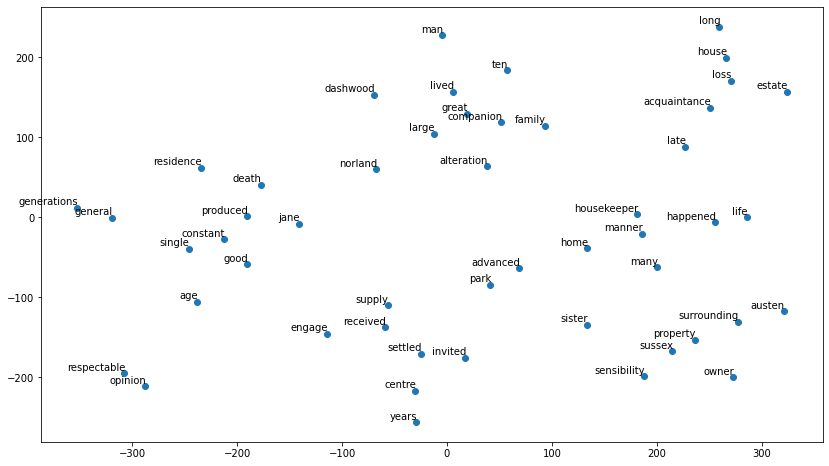

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50 

T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [idx2word[i+1] for i in range(plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')                      	                        


**10. Resources used**

http://jalammar.github.io/illustrated-word2vec/
https://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/ 
https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa 
https://adventuresinmachinelearning.com/word2vec-keras-tutorial/ 
https://www.tensorflow.org/tutorials/representation/word2vec#the_skip-gram_model 
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py 

